### Hedging with Real SPX Option Data

We implement and evaluate delta hedging strategeis for SPX index European call options using real market data. Create a standardized set of calibration and hedging metrics so that results that are comparable.

#### Dataset

The dataset consists of SPX call option quotes (WRDS export) over the period 2023-02-01 to 2023-02-28. For each trading date $t$ and each option contract (strike $K$, expiry $T$), the dataset contains at least

```
(date, exdate, symbol, strike price, best bid, best offer, impl volatility, delta, cp flag)
```

Use ```cp_flag = 'C'``` (calls only).

*NOTE:* Let $S_t$ denote the SPX close on date $t$. If $S_t$ is not included in the WRDS export, we must source it externally and merge it by date. 

Let $t$ index trading days. For any end-of-day quantity $X_t$ define

$$\Delta X_t := X_{t+1} - X_t$$

**Midquote:** Define the call option midquote by $V_t$ by:

$$V_t := \frac{\text{bid}_t + \text{ask}_t}{2} \quad \text{(use best bid/offer if available).}$$

**Maturity:** Define the days-to-expiration and year fraction:

$$D_t := (T - t) \text{ in days}, \quad \tau_t := \frac{D_t}{365}.$$

**Underlying:** Let $S_t$ denote the SPX close, with one-day change $$\Delta S_t := S_{t+1} - S_t$$

**Delta-hedge residual:**: Given a delta hedge process $\delta t$ define the hedging residual:

$$\varepsilon_t(\delta) := \Delta V_t - \delta_t \Delta S_t.$$

**SSE and Gain:** For a set of observations $\mathcal{I}$, define:

$$\text{SSE}_{\mathcal{I}}(\delta) := \sum_{t \in \mathcal{I}} \varepsilon_t(\delta)^2.$$

Given two delta hedges, define the Gain:

$$\text{Gain}(A \text{ vs } B) := 1 - \frac{\text{SSE}(\delta^{(A)})}{\text{SSE}(\delta^{(B)})}$$

where both SSEs are computed over the same observation set.

*NOTE*: The competitive score will be based on SSE and Gain computed after the filtering and bucketing (Step 6).

#### Step 1: Data loading and cleaning

Load the option panel and apply the following preprocessing

- Keep calls only
- Convert dates to consistent format
- Rescale striks if needed to sthat strikes are in index-point units
- Construct the midquote $V_t$
- Remove observations with missing or invalid implied volatility

In [43]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Load raw data
raw = pd.read_csv("data/option20230201_20230228.csv")
print(f"Raw rows: {len(raw)}")

# Filter to calls only
df = raw[raw["cp_flag"] == "C"].copy()
print(f"Rows after filtering to calls: {len(df)}")

# Convert dates
df["date"] = pd.to_datetime(df["date"])
df["exdate"] = pd.to_datetime(df["exdate"])

# Rescale strikes (WRDS stores strike × 1000)
df["strike_price"] = df["strike_price"] / 1000

# Construct midquote
df["Vt"] = (df["best_bid"] + df["best_offer"]) / 2

# Remove zero-midquote rows (bid=0 and ask=0)
before_zero = len(df)
df = df[df["Vt"] > 0]
print(f"Dropped {before_zero - len(df)} zero-midquote rows, remaining: {len(df)}")

# Remove missing/invalid implied volatility
before_iv = len(df)
df = df[df["impl_volatility"].notna() & (df["impl_volatility"] > 0)]
print(f"Dropped {before_iv - len(df)} missing/invalid IV rows, remaining: {len(df)}")

Raw rows: 175301
Rows after filtering to calls: 175301
Dropped 0 zero-midquote rows, remaining: 175301
Dropped 21573 missing/invalid IV rows, remaining: 153728


**Required Reporting:**

- Row counts before/after filtering to calls
- Number of unique trading dates and unique expiries
- Missing rates of ($V_t$, $\sigma_{mkt}$, $\delta$)
- The list of final columns kept for the project

In [44]:
# Required Reporting 

# Row counts before/after filtering
print("=" * 50)
print("Row Counts")
print(f"  Raw dataset:              {len(raw)}")
print(f"  After calls filter:       {len(raw[raw['cp_flag'] == 'C'])}")
print(f"  After zero-midquote drop: {before_zero - (before_zero - len(df) + (before_iv - len(df)))}")  
print(f"  After IV filter (final):  {len(df)}")

# Unique trading dates and expiries
print("\n" + "=" * 50)
print("Dates")
print(f"  Unique trading dates: {df['date'].nunique()}")
print(f"  Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"  Unique expiries:      {df['exdate'].nunique()}")

# Missing rates for key columns
print("\n" + "=" * 50)
print("Missing Rates (after cleaning)")
for col in ["Vt", "impl_volatility", "delta"]:
    miss = df[col].isna().sum()
    print(f"  {col:20s}: {miss}/{len(df)} ({100*miss/len(df):.2f}%)")

# Final columns to keep
keep_cols = [
    "date", "exdate", "symbol", "strike_price",
    "best_bid", "best_offer", "Vt",
    "impl_volatility", "delta", "cp_flag"
]
df = df[keep_cols]

print("\n" + "=" * 50)
print("Final Columns")
print(f"  {keep_cols}")
print(f"  Final shape: {df.shape}")

Row Counts
  Raw dataset:              175301
  After calls filter:       175301
  After zero-midquote drop: 132155
  After IV filter (final):  153728

Dates
  Unique trading dates: 19
  Date range: 2023-02-01 to 2023-02-28
  Unique expiries:      67

Missing Rates (after cleaning)
  Vt                  : 0/153728 (0.00%)
  impl_volatility     : 0/153728 (0.00%)
  delta               : 0/153728 (0.00%)

Final Columns
  ['date', 'exdate', 'symbol', 'strike_price', 'best_bid', 'best_offer', 'Vt', 'impl_volatility', 'delta', 'cp_flag']
  Final shape: (153728, 10)


#### Step 2: Constract time seriesa nd one-day option changes

Construct a contract identifier that tracks the same option over time (e.g. using ```symbol```). Within each contract, compute one-day changes

$$
\Delta V_t = V_{t+1} - V_t
$$

and keep only observations for which $\Delta V_t$ is defined.

In [45]:
df = df.sort_values(["symbol", "date"])
df["delta_Vt"] = df.groupby("symbol")["Vt"].diff(-1) * (-1)

trading_dates = sorted(df["date"].unique())
date_rank = {d: i for i, d in enumerate(trading_dates)}

df["date_rank"] = df["date"].map(date_rank)
df["next_date_rank"] = df.groupby("symbol")["date_rank"].shift(-1)  # <-- this was missing

df.loc[df["next_date_rank"] != df["date_rank"] + 1, "delta_Vt"] = np.nan  # <-- only this line, remove the pd.NaT one

df = df.drop(columns=["date_rank", "next_date_rank"])

before_delta = len(df)
df_step2 = df[df["delta_Vt"].notna()].copy()
print(f"Rows before Delta_Vt filter: {before_delta}")
print(f"Rows after Delta_Vt filter:  {len(df_step2)}")

Rows before Delta_Vt filter: 153728
Rows after Delta_Vt filter:  135386


**Required Reporting:**
- summary statistics of $V_t$ and and $\Delta V_t$
- number of contracts retained after constructing $\Delta V_t$

In [46]:
# Required Reporting
print("\n" + "-" * 50)
print("Vt")
print(df_step2["Vt"].describe().round(4))

print("\n" + "-" * 50)
print("Delta_Vt")
print(df_step2["delta_Vt"].describe().round(4))

print("\n" + "-" * 50)
n_contracts = df_step2["symbol"].nunique()
print(f"Number of unique contracts retained: {n_contracts}")


--------------------------------------------------
Vt
count    135386.0000
mean        399.3788
std         537.2200
min           0.0250
25%          31.8000
50%         187.1000
75%         559.1875
max        3945.6000
Name: Vt, dtype: float64

--------------------------------------------------
Delta_Vt
count    135386.0000
mean         -5.8744
std          25.7089
min        -119.3000
25%         -20.0500
50%          -2.0250
75%           4.4500
max          70.2000
Name: delta_Vt, dtype: float64

--------------------------------------------------
Number of unique contracts retained: 11004


#### Step 3: Underlying SPX merge and one-day underlying changes

Obtain the SPX close series ${S_t}$ over the full sample and compute:

$$
\Delta S_t = S_{t+1} - S_t
$$

Merge $S_t$ and $\Delta S_t$ into the option panel by date.

In [47]:
# Download SPX close via yfinance 
# end is exclusive in yfinance, so we use 2023-03-03 to include 2023-03-02
spx = yf.download("^GSPC", start="2023-02-01", end="2023-03-03")[["Close"]]
spx.columns = spx.columns.droplevel(1)
spx = spx.rename(columns={"Close": "St"})
spx.index = pd.to_datetime(spx.index)

[*********************100%***********************]  1 of 1 completed


In [48]:
# Compute Delta_St = S(t+1) - S(t)
spx["delta_St"] = spx["St"].shift(-1) - spx["St"]
print(spx.head())

Price                St   delta_St
Date                              
2023-02-01  4119.209961  60.549805
2023-02-02  4179.759766 -43.279785
2023-02-03  4136.479980 -25.399902
2023-02-06  4111.080078  52.919922
2023-02-07  4164.000000 -46.140137


In [49]:
# Merge into option panel by date 
df_step2 = df_step2.merge(spx, left_on="date", right_index=True, how="left")

**Required Reporting:**
- Merge coverage: % of the option observations matched to valid ($S_t, \Delta S_t$)
- Summary statistics of $S_t$ and $\Delta S_t$
- One plot of $S_t$ and one plot of $\Delta S_t$ over time

In [50]:
# Required Reporting
matched = df_step2["St"].notna().sum()
print(f"\nMerge coverage: {matched}/{len(df_step2)} ({100*matched/len(df_step2):.1f}%)")

print("\n" + "=" * 50)
print("St")
print(df_step2["St"].describe().round(2))

print("\n" + "=" * 50)
print("Delta_St")
print(df_step2["delta_St"].describe().round(2))


Merge coverage: 135386/135386 (100.0%)

St
count    135386.00
mean       4084.76
std          65.18
min        3970.04
25%        4012.32
50%        4090.46
75%        4136.48
max        4179.76
Name: St, dtype: float64

Delta_St
count    135386.00
mean         -8.88
std          37.86
min         -81.75
25%         -42.28
50%         -11.32
75%          12.20
max          60.55
Name: delta_St, dtype: float64


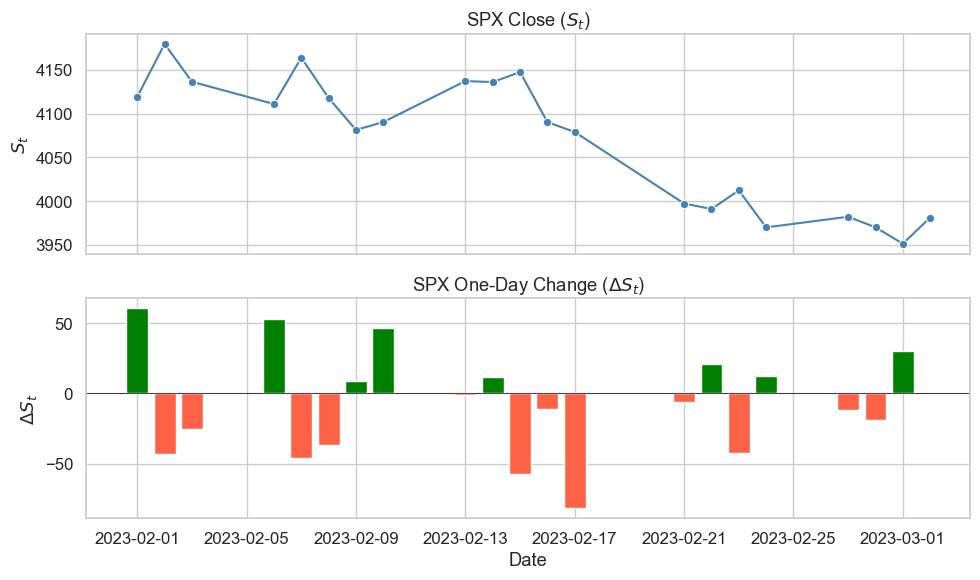

In [52]:
sns.set_theme(style="whitegrid", font_scale=1.1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot St
sns.lineplot(x=spx.index, y=spx["St"], ax=ax1, marker="o", color="steelblue", linewidth=1.5)
ax1.set_title("SPX Close ($S_t$)")
ax1.set_ylabel("$S_t$")

# Plot ΔSt
delta = spx["delta_St"].dropna()
colors = ["green" if v >= 0 else "tomato" for v in delta]
ax2.bar(delta.index, delta.values, color=colors, width=0.8)
ax2.axhline(0, color="black", linewidth=0.5)
ax2.set_title("SPX One-Day Change ($\\Delta S_t$)")
ax2.set_ylabel("$\\Delta S_t$")
ax2.set_xlabel("Date")

fig.tight_layout()
plt.show()

#### Step 4: Stripping a daily risk-free curve with NSS model and extracting $r_t(\tau)$